In [2]:
import numpy as np
import argparse
import csv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
np.random.seed(42)
import math
import random

In [19]:
LEARNING_RATE = 0.51
BATCH_SIZE = 4
NUM_ITER = 9000
MAX_POWER = 7
SUBSET = 100
N_FOLDS = 10
ERROR = "huber"
REGULARIZATION_LAMBDA = 1e-6

In [4]:
def readData(filename):
    dataset = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            dataset.append([float(row[0]),float(row[1])])
    return dataset
dataset = readData('gaussian.csv')

In [5]:
dataset = dataset[:SUBSET]

In [6]:
def cross_validation_split(dataset):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / N_FOLDS)
    for i in range(N_FOLDS):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [7]:
# highest power is m here
def makeDesignMat(x,m):
    return np.vander(x,m+1,increasing=True)

In [8]:
def chunkarr(arr,n):
    return [arr[i:i + n] for i in range(0, len(arr), n)]

In [9]:
def plot_error(train_err_list,test_err_list):
    xa = np.linspace(1,len(train_err_list),len(train_err_list),dtype=int)
    plt.figure()
    plt.plot(xa,train_err_list,color="g")
    plt.plot(xa,test_err_list,color="r")
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Error vs Iterations')
    plt.show()

In [10]:
def descent(trainX,y,testX,testY,lambd = 0.0, err_function = "mse" ):
    #m = len(trainX)
    w = np.random.rand(MAX_POWER+1)
    y = np.array(y)
    X = makeDesignMat(trainX,MAX_POWER)
    Xchunks = chunkarr(X,BATCH_SIZE)
    ychunks = chunkarr(y,BATCH_SIZE)
    train_err_list = []
    test_err_list = []
    for i in tqdm(range(NUM_ITER)):
        for chunk in range(len(Xchunks)):
            Xcon = Xchunks[chunk]
            ycon = ychunks[chunk]
            pred = np.dot(Xcon,w)
            test_err_list.append(testError(testX,testY,w))
            if err_function == "mse":
                err = 0.5 * (np.sum(np.square(pred-ycon)) + lambd*np.sum(np.square(w)))/len(ycon)
                grad = (np.dot(Xcon.T,(pred-ycon)) + lambd*w)/len(ycon)
            if err_function == "mae":
                err = np.sum(np.abs(pred-ycon))
                parity = np.sign(pred - ycon)
                parity = parity.reshape((len(ycon),1))
                grad = np.sum(np.multiply(parity,Xcon).T,axis=1)/len(ycon)
            if err_function == "huber":
                e = 0.1
                temp = pred-ycon
                err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e)))
                err += lambd*np.sum(np.square(w))
                err /= len(ycon)
                grad = np.zeros((MAX_POWER+1,))
                for i in range(len(ycon)):
                    if np.abs(temp[i]<=e):
                        grad += temp[i]*Xcon[i,:]
                    else:
                        grad += e*np.sign(temp[i])*Xcon[i,:]
                grad+=2*lambd*w
                w = np.squeeze(w)
                grad /=len(ycon)
                grad = np.squeeze(grad)
            w = w - LEARNING_RATE * grad
            train_err_list.append(err)
    plot_error(train_err_list,test_err_list)
    return w

In [11]:
def plot_reg(trainX,trainY,testX,testY,w):
    def aux(X_line,w):
        temp = 0
        for i in range(len(w)):
            temp += np.power(X_line,i) * w[i]
        return temp
    jointX = np.concatenate((trainX,testX))
    plt.scatter(trainX,trainY,color='b',marker ='o',s=15)
    plt.scatter(testX,testY,color="m",marker='o',s=30)
    x_line = np.linspace(min(jointX),max(jointX),100)
    y_pred = aux(x_line,w)
    plt.plot(x_line,y_pred, color='g')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.show()

In [12]:
def testError(testX, testY,w):
    testX = makeDesignMat(testX,MAX_POWER)
    pred = np.dot(testX,w)
    if ERROR == "mse":
        err = 0.5 * (np.sum(np.square(pred-testY)))/len(testY)
    elif ERROR == "mae":
        err = np.sum(np.abs(pred-testY)) / len(testY)
    elif ERROR == "huber":
        e = 0.1
        temp = pred-testY
        err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e))) / len(testY)
    return err

In [13]:
def evaluate(dataset):
    folds = cross_validation_split(dataset)
    err_list = []
    for fold in folds:
        trainDS = list(folds)
        trainDS.remove(fold)
        trainDS = np.array(trainDS)
        trainX = []
        trainY = []
        for i in range(len(trainDS)):
            trainX.extend(trainDS[i][:,0])
            trainY.extend(trainDS[i][:,1])
        testDS = np.array(fold)
        testX = testDS[:,0]
        testY = testDS[:,1]
        w = descent(trainX,trainY,testX,testY,REGULARIZATION_LAMBDA,ERROR)
        plot_reg(trainX,trainY,testX,testY,w)
        err = testError(testX,testY,w)
        err_list.append(err)
    avg_error = np.mean(err_list)
    print(err_list)
    return avg_error

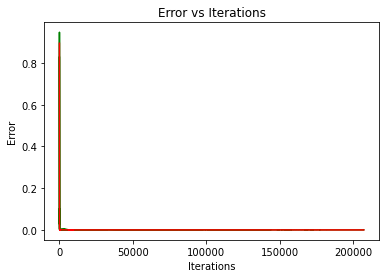

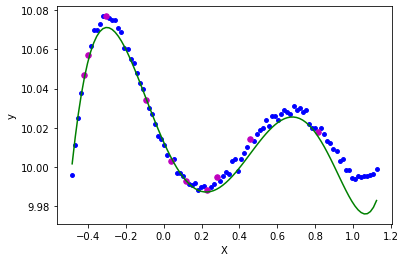

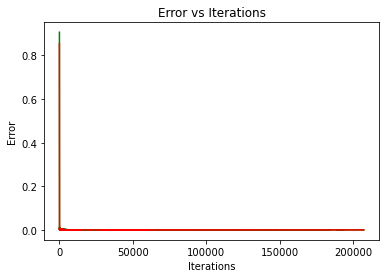

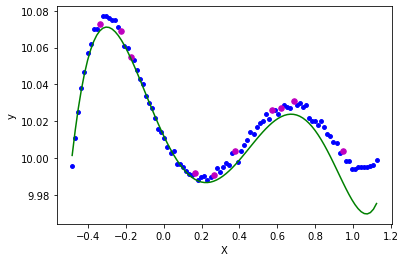

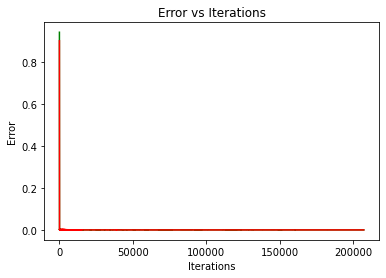

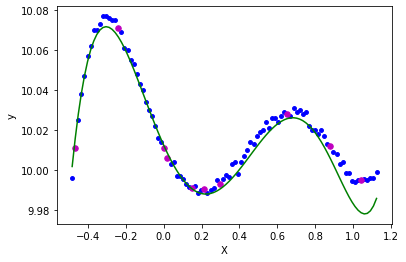

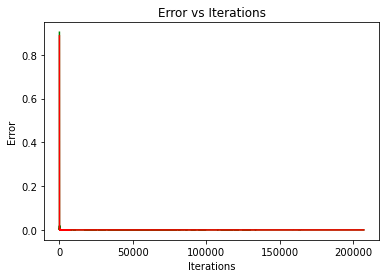

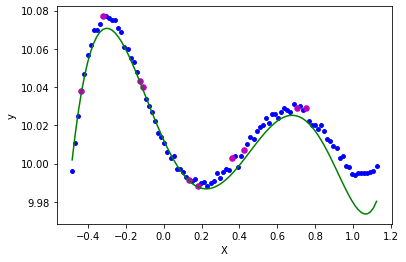

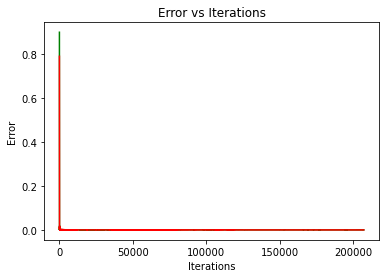

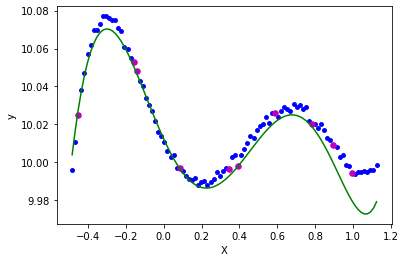

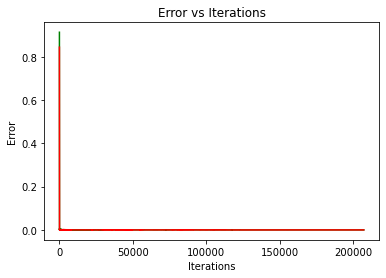

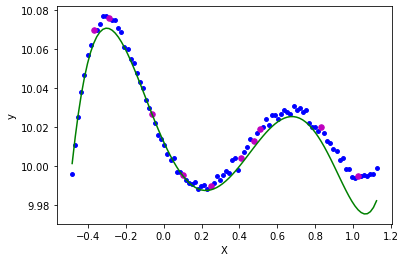

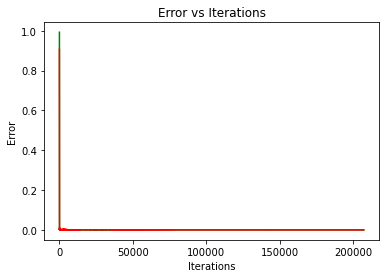

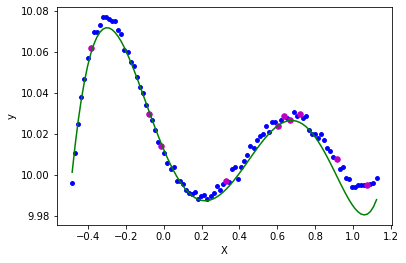

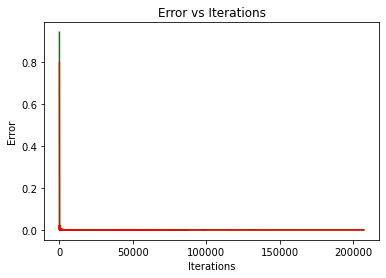

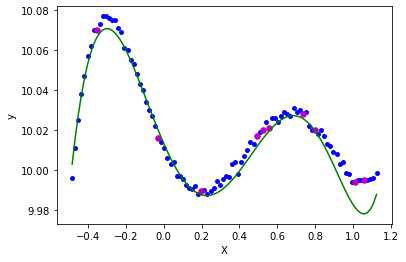

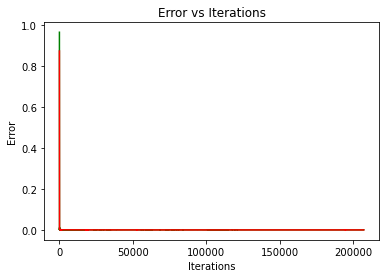

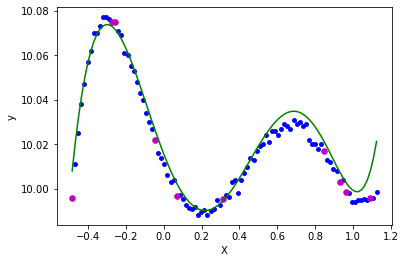

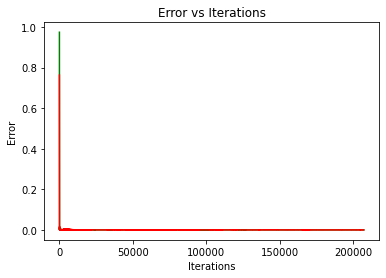

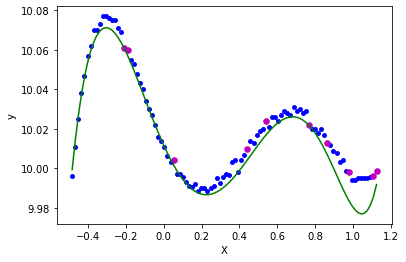

[7.810013324329651e-06, 2.6481456802071686e-05, 1.8898438932422836e-05, 1.0081678325158654e-05, 1.7831807403084033e-05, 2.495445176174119e-05, 1.6342209188817917e-05, 2.680782091895674e-05, 2.0967270202852268e-05, 2.5363955198735986e-05]


1.9553910205817097e-05

In [20]:
evaluate(dataset)

In [31]:
def evaluate_moorepenrose(dataset):
    folds = cross_validation_split(dataset)
    err_list = []
    for fold in folds:
        trainDS = list(folds)
        trainDS.remove(fold)
        trainDS = np.array(trainDS)
        trainX = []
        trainY = []
        for i in range(len(trainDS)):
            trainX.extend(trainDS[i][:,0])
            trainY.extend(trainDS[i][:,1])
        testDS = np.array(fold)
        testX = testDS[:,0]
        testY = testDS[:,1]
        X = makeDesignMat(trainX,MAX_POWER)
        #w = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),np.dot(X.transpose(),trainY))
        w = np.dot(np.linalg.inv(np.dot(X.transpose(),X) + REGULARIZATION_LAMBDA * np.identity(MAX_POWER+1) ),np.dot(X.transpose(),trainY))
        plot_reg(trainX,trainY,testX,testY,w)
        err = testError(testX,testY,w)
        err_list.append(err)
    avg_error = np.mean(err_list)
    print(err_list)
    return avg_error

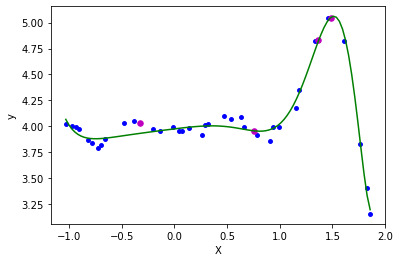

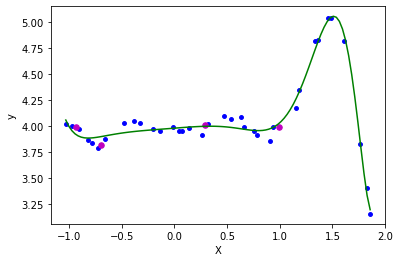

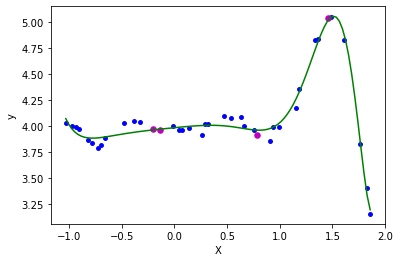

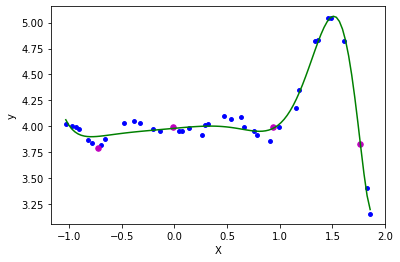

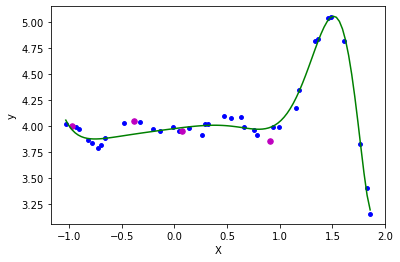

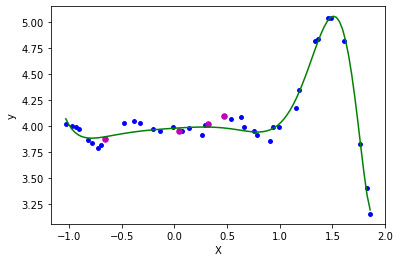

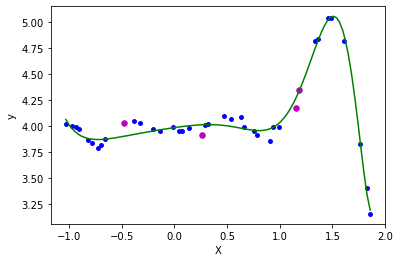

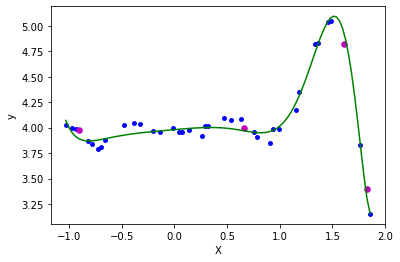

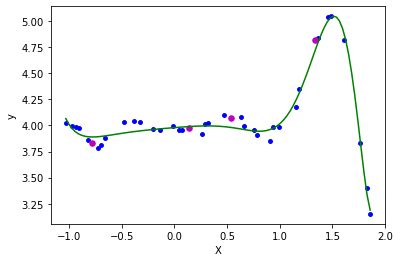

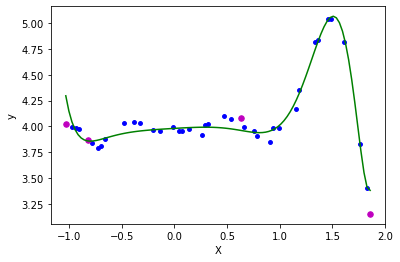

[0.0013414588703155267, 0.001696625349827656, 0.00040149608577505133, 0.001649909193109413, 0.004219886449786533, 0.0018996742356776816, 0.004199895382120354, 0.0031777908162292138, 0.002733307785572212, 0.01193638529083909]


0.003325642945925273

In [32]:
evaluate_moorepenrose(dataset)